In [1]:
from amacrine_color_schema import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Connecting sstrauss@172.25.240.205:3306


Load kernels

In [2]:
key_kernel = {
                'experimenter': 'Korympidou',
                'artefact_kernel_id': 1,
                'preprocess_param_set_id': 1,
                'stim_id': 15,
                'noise_id': 1,
                'param_id': 1
            }

kernels = pd.DataFrame.from_dict((CorrectedBGFlickerKernels() *
                                   Pharmacology() *
                                   PharmInfo() *
                                   MinMaxQuality() &
                                   'pharmaflag = 1' & 
                                   'control_flag = 0' &
                                   key_kernel).fetch(as_dict=True))

assert np.all(kernels['treatment'] != 'control')

Unravel dataframe so that each row is one ROI

In [3]:
columns = ['date', 'exp_num', 'field_id', 'roi', 
           'uv_center_drug', 'uv_ring_drug', 'uv_surround_drug', 
           'green_center_drug', 'green_ring_drug', 'green_surround_drug',
           'treatment', 'concentration', 'multiple_drug_flag', 
           'drug', 'quality_values_drug']
df = pd.DataFrame(columns=columns)

for index, row in kernels.iterrows():
    
    nb_rois = row['st_kernels_uv_corrected'].shape[1]

    current_data = {'date': np.repeat(row['date'], nb_rois), 
                    'exp_num': np.repeat(row['exp_num'], nb_rois), 
                    'field_id': np.repeat(row['field_id'], nb_rois), 
                    'roi': np.arange(1,nb_rois+1),
                    'uv_center_drug': list(row['st_kernels_uv_corrected'][:,:,0].T),
                    'uv_ring_drug': list(row['st_kernels_uv_corrected'][:,:,1].T), 
                    'uv_surround_drug': list(row['st_kernels_uv_corrected'][:,:,2].T),
                    'green_center_drug':list(row['st_kernels_green_corrected'][:,:,0].T), 
                    'green_ring_drug': list(row['st_kernels_green_corrected'][:,:,1].T), 
                    'green_surround_drug': list(row['st_kernels_green_corrected'][:,:,2].T),
                    'treatment': np.repeat(row['treatment'], nb_rois), 
                    'concentration': np.repeat(row['concentration'], nb_rois),
                    'multiple_drug_flag': np.repeat(row['multiple_drug_flag'], nb_rois),
                    'drug': np.repeat(row['drug'], nb_rois),
                    'quality_values_drug': row['quality_values']
                   }
    
    df = pd.concat([df, pd.DataFrame(current_data, columns = columns)], ignore_index = True)

Load Chirp and Local Chirp

In [4]:
key_chirp_g = {
                'experimenter': 'Korympidou',
                'stim_id': 5,
                'preprocess_param_set_id': 1,
                'resample_f_id': 3
            }
global_chirp = pd.DataFrame.from_dict((NormalizedChirp() * Pharmacology() * PharmInfo() &
                                       'control_flag = 0' & 'pharmaflag = 1' & key_chirp_g).fetch(as_dict=True))
global_chirp = global_chirp.rename(columns={'time_bin': 'time_bin_global_chirp_drug',
                                            'normalized_chirp': 'global_chirp_drug'})


key_chirp_l = {
                'experimenter': 'Korympidou',
                'stim_id': 6,
                'preprocess_param_set_id': 1,
                'resample_f_id': 3
            }
local_chirp = pd.DataFrame.from_dict((NormalizedChirp() * Pharmacology() * PharmInfo() &
                                     'control_flag = 0' & 'pharmaflag = 1' & key_chirp_l).fetch(as_dict=True))
local_chirp = local_chirp.rename(columns={'time_bin': 'time_bin_local_chirp_drug', 
                                          'normalized_chirp': 'local_chirp_drug'})

assert np.all(global_chirp['treatment'] != 'control')
assert np.all(local_chirp['treatment'] != 'control')

Drop unnecessary columns

In [5]:
drop = ['experimenter', 'stim_id', 'presentation_id', 'preprocess_param_set_id', 
        'resample_f_id', 'control_flag', 'pharmaflag', 'pharmconc', 'pharmcom']

global_chirp = global_chirp.drop(drop, axis = 1)
local_chirp = local_chirp.drop(drop, axis = 1)

Merge different dataframes

In [6]:
match_on = ['date', 'exp_num', 'field_id', 'roi', 'treatment', 'concentration', 'multiple_drug_flag', 'drug']

interm = df.merge(global_chirp, how='inner', on=match_on)
all_data = interm.merge(local_chirp, how='inner', on=match_on)

Drop 50 um ubp experiments

In [7]:
ubp_df = all_data[all_data['drug'] == 'UBP310']
print(ubp_df['concentration'].unique())

drop_index = all_data[(all_data['treatment'] == 'UBP310') &
                      (all_data['drug'] == 'UBP310') &
                      (all_data['concentration'] == '50')].index
print(all_data.shape)
all_data.drop(drop_index, inplace = True)
all_data.reset_index(drop=True, inplace=True)
print(all_data.shape)
ubp_df = all_data[all_data['drug'] == 'UBP310']
print(ubp_df['concentration'].unique())

['10' '50']
(4570, 19)
(4333, 19)
['10']


Load control ROIs and merge

In [8]:
control_data = pd.read_pickle('Data/ACs/Dataframes/control_data_gmm_pcaColor_3Components_labels.pkl')

In [9]:
match_on = ['date', 'exp_num', 'field_id', 'roi']

control_drug_data = all_data.merge(control_data, how='inner', on=match_on)

Check time bins for Chirp

In [10]:
referenceA = control_drug_data['time_bin_local_chirp_drug'].iloc[0]
referenceB = control_drug_data['time_bin_global_chirp_drug'].iloc[0]
assert np.all(referenceA == referenceB)

for index, row in control_drug_data.iterrows():
    assert np.all(referenceA == row['time_bin_local_chirp_drug'])
    assert np.all(referenceB == row['time_bin_global_chirp_drug'])

Kernel polarity and amplitude

In [11]:
labels = ['uv_center', 'uv_ring', 'uv_surround', 'green_center', 'green_ring', 'green_surround']
len_kernel = 1250
assert len(all_data['uv_center_drug'].iloc[0]) == len_kernel
stop_kernel = int(len_kernel*3/4)
start_kernel = (MinMaxQualityParams() & 'param_id = 1').fetch1('start_kernel')
kernel_threshold = 0.1

for current_label in labels:
    
    current_data = np.vstack(control_data[current_label].to_numpy())[:,0:stop_kernel]
    current_drug_data = np.vstack(control_drug_data[current_label + '_drug'].to_numpy())[:,0:stop_kernel]
    
    pca = PCA(n_components=3, random_state=0)
    X_transformed = pca.fit_transform(current_data)
    drug_transformed = pca.transform(current_drug_data)
    
    if current_label == 'uv_surround' or current_label == 'green_surround':
        polarity = (X_transformed[:,0]<0)*1
        control_drug_data[current_label + '_drug' + ' polarity'] = list((drug_transformed[:,0]<0)*1)
    else:
        polarity = (X_transformed[:,0]>0)*1
        control_drug_data[current_label + '_drug' + ' polarity'] = list((drug_transformed[:,0]>0)*1)
    
    min_ = np.amin(current_data[:,start_kernel:], axis=1)
    max_ = np.amax(current_data[:,start_kernel:], axis=1)
       
    # Compare calculation
    amplitude = np.abs(max_ - min_)
    sign = np.ones(len(control_data))
    off_rois = np.where(polarity == 0)[0]
    sign[off_rois] = -1
    assert np.all(control_data[current_label + ' amplitude'].to_numpy() == amplitude*sign)
    
    # Amplitude computation on drug data
    min_ = np.amin(current_drug_data[:,start_kernel:], axis=1)
    max_ = np.amax(current_drug_data[:,start_kernel:], axis=1)
       
    # Calculate kernel amplitude
    amplitude = np.abs(max_ - min_)
    sign = np.ones(len(control_drug_data))
    control_drug_data[current_label + '_drug' + ' quality'] = list((amplitude>kernel_threshold)*1)
    off_rois = np.where(control_drug_data[current_label + '_drug' +' polarity'].to_numpy() == 0)[0]
    sign[off_rois] = -1
    control_drug_data[current_label + '_drug' + ' amplitude'] = amplitude*sign
    
quality_all_drug = np.column_stack((control_drug_data['uv_center_drug amplitude'].to_numpy(),
                                    control_drug_data['uv_ring_drug amplitude'].to_numpy(),
                                    control_drug_data['green_center_drug amplitude'].to_numpy(),
                                    control_drug_data['green_ring_drug amplitude'].to_numpy(),
                                    control_drug_data['green_surround_drug amplitude'].to_numpy()))
assert np.all(control_drug_data['quality_values_drug'].to_numpy() == np.amax(np.abs(quality_all_drug), axis = 1))

Quality filter ROIs

In [12]:
control_drug_data = control_drug_data[control_drug_data['quality_values_drug']>0.1] # DRUG DRUG DRUG
control_drug_data = control_drug_data.reset_index(drop=True)

print(np.amin(control_drug_data['quality_values_drug']))
print(np.amin(control_drug_data['quality_values']))

0.10000105906140301
0.10001667453491629


Plot quality distribution

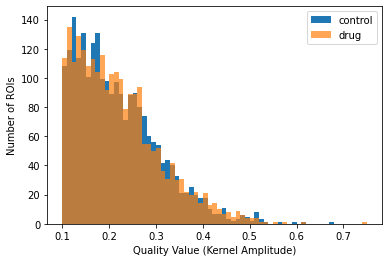

In [13]:
q_control = control_drug_data['quality_values'].to_numpy()
q_drug = control_drug_data['quality_values_drug'].to_numpy()

max_value = np.amax((np.amax(q_control), np.amax(q_drug)))
min_value = np.amin((np.amin(q_control), np.amin(q_drug)))

bin_width = 0.01
bins = np.arange(min_value, max_value + bin_width, bin_width)

plt.hist(q_control, bins, label = 'control')
plt.hist(q_drug, bins, alpha = 0.7, label = 'drug')
plt.legend()
plt.xlabel('Quality Value (Kernel Amplitude)')
plt.ylabel('Number of ROIs')
plt.show()

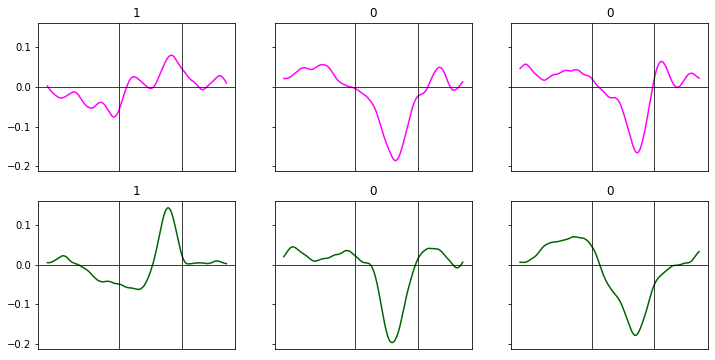

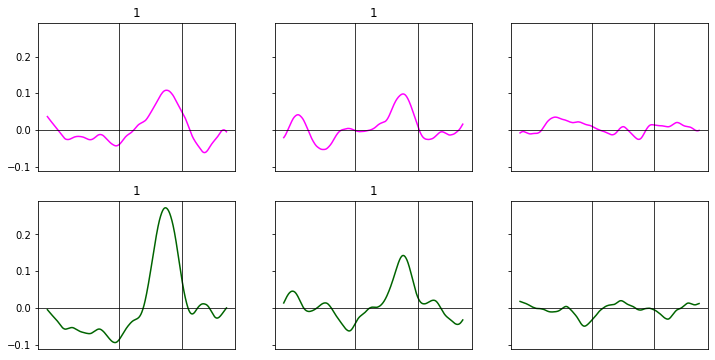

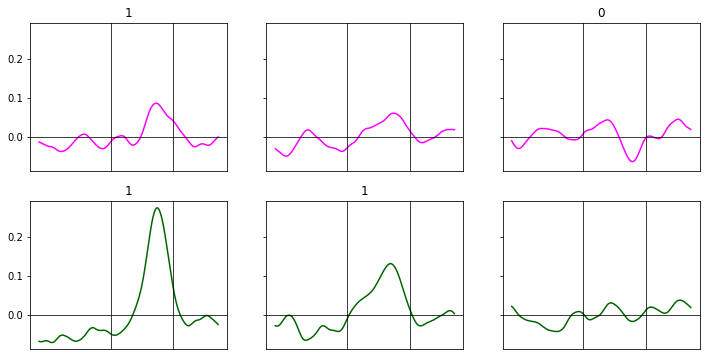

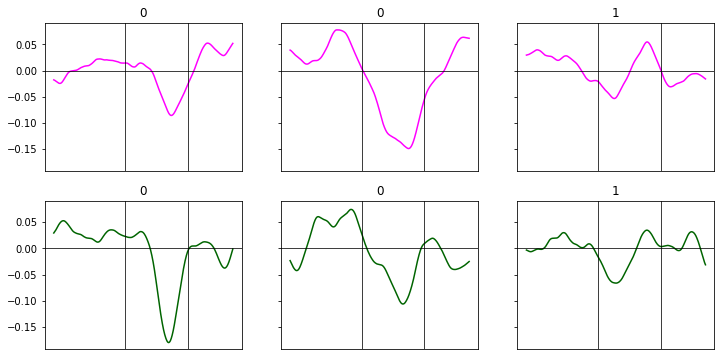

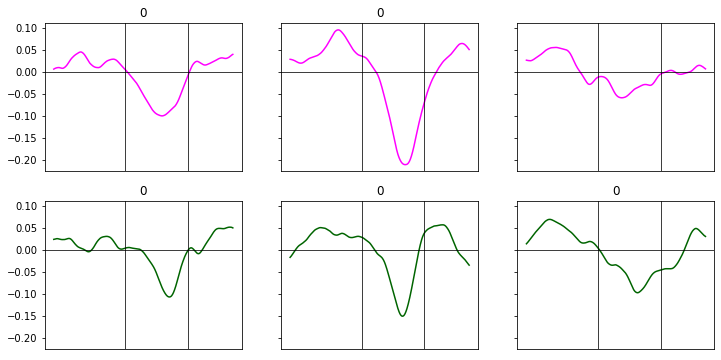

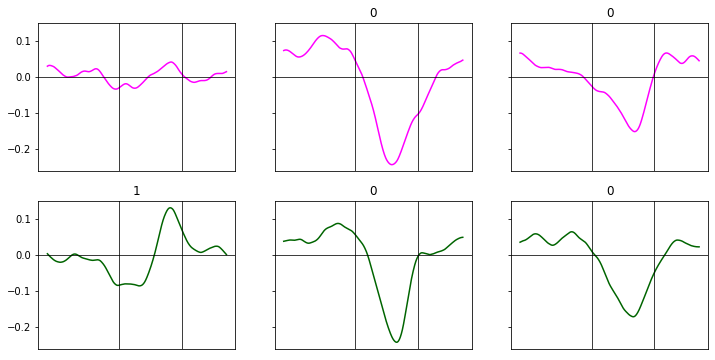

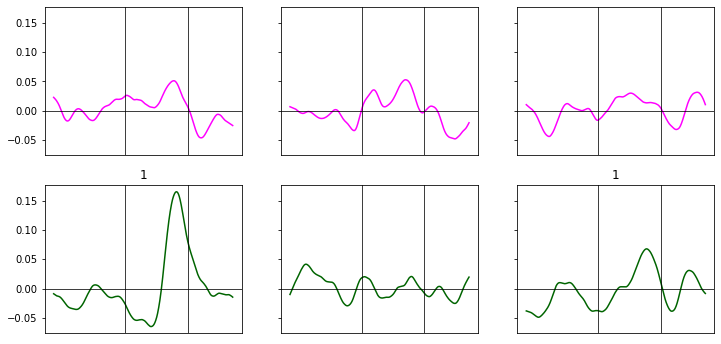

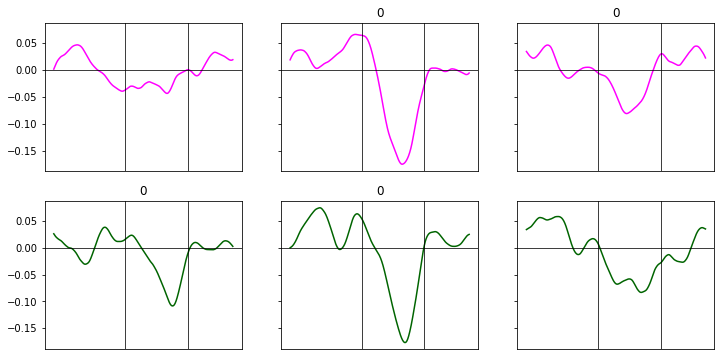

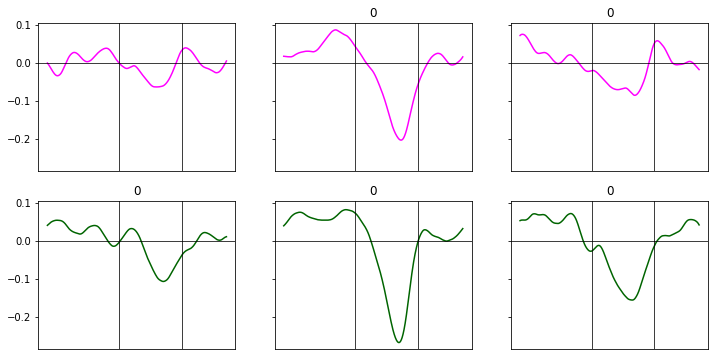

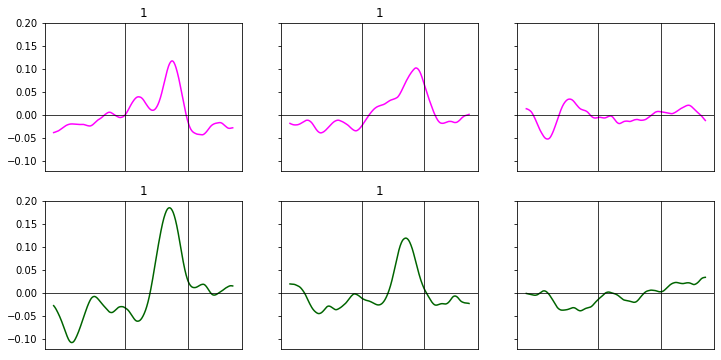

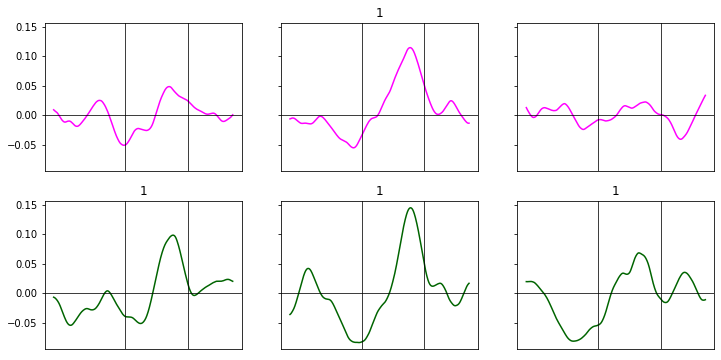

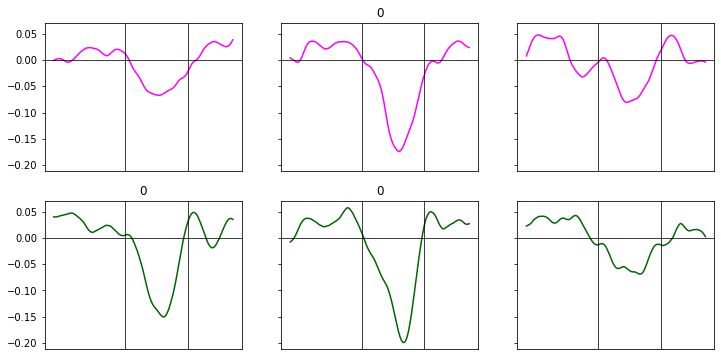

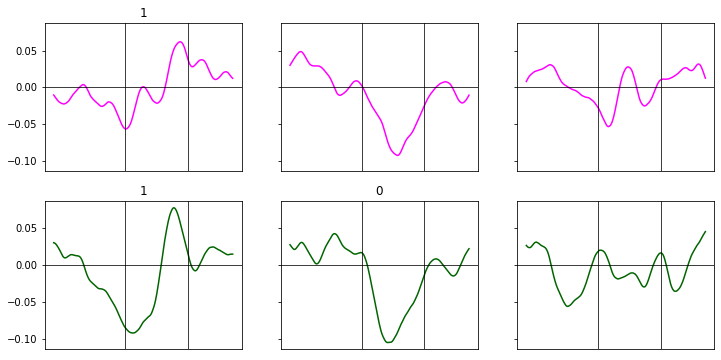

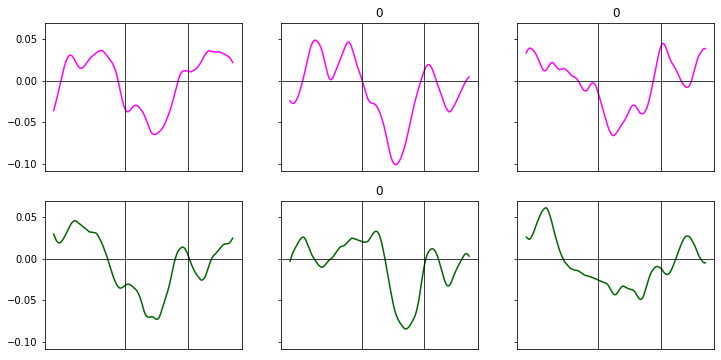

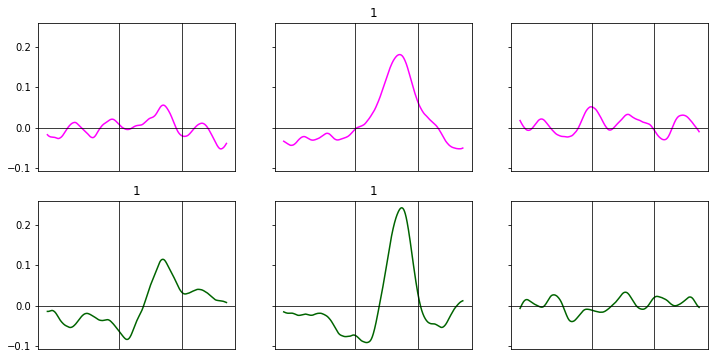

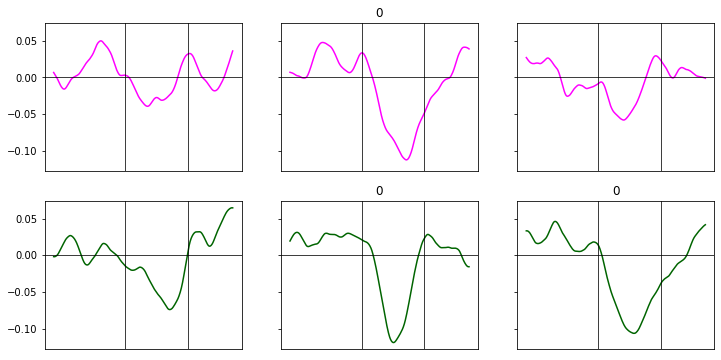

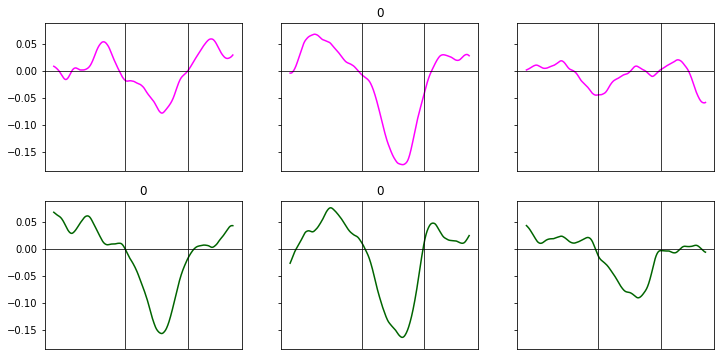

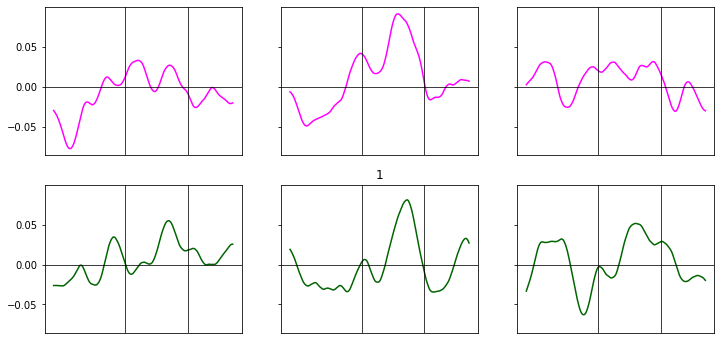

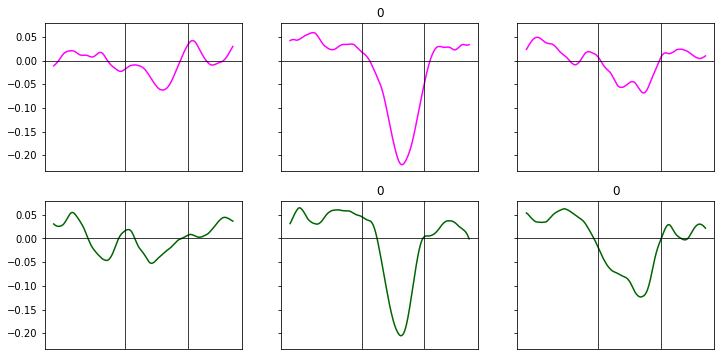

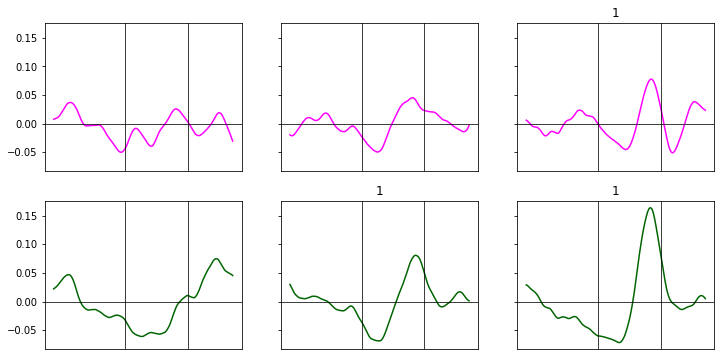

In [14]:
labels = ['uv_center_drug', 'uv_ring_drug', 'uv_surround_drug', 
          'green_center_drug', 'green_ring_drug', 'green_surround_drug']

for roi in range(0,20):
    fig, ax = plt.subplots(2,3, figsize=(12,6), sharey = 'all')
    for index, label in enumerate(labels[0:3]):
        ax[0,index].plot(control_drug_data[label].iloc[roi], color = 'magenta')
        if control_drug_data[label + ' quality'].iloc[roi]:
             ax[0,index].set_title(control_drug_data[label + ' polarity'].iloc[roi])
        ax[0,index].axvline(stop_kernel, color = 'black', linewidth = 0.75)
        ax[0,index].axvline(start_kernel, color = 'black', linewidth = 0.75)
        ax[0,index].axhline(0, color = 'black', linewidth = 0.75)
        ax[0,index].set_xticks([])

    for index, label in enumerate(labels[3:]):
        ax[1,index].plot(control_drug_data[label].iloc[roi], color = 'darkgreen')
        if control_drug_data[label + ' quality'].iloc[roi]:
             ax[1,index].set_title(control_drug_data[label + ' polarity'].iloc[roi])
        ax[1,index].axvline(stop_kernel, color = 'black', linewidth = 0.75)
        ax[1,index].axvline(start_kernel, color = 'black', linewidth = 0.75)
        ax[1,index].axhline(0, color = 'black', linewidth = 0.75)
        ax[1,index].set_xticks([])
    plt.show()

Save dataframe

In [15]:
#control_drug_data.to_pickle('Data/ACs/Dataframes/control_drug_data_gmm_pcaColor_3Components_labels.pkl')